In [16]:
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
path = 'archive-2/architectural-styles-dataset'

batch_size = 32 
img_height = 160
img_width = 160

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=123,          # 123 is aribtary, could be any integer. 
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 10113 files belonging to 25 classes.
Using 8091 files for training.


2023-04-25 12:31:38.139760: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    path, 
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width), 
    batch_size=batch_size
)

Found 10113 files belonging to 25 classes.
Using 2022 files for validation.


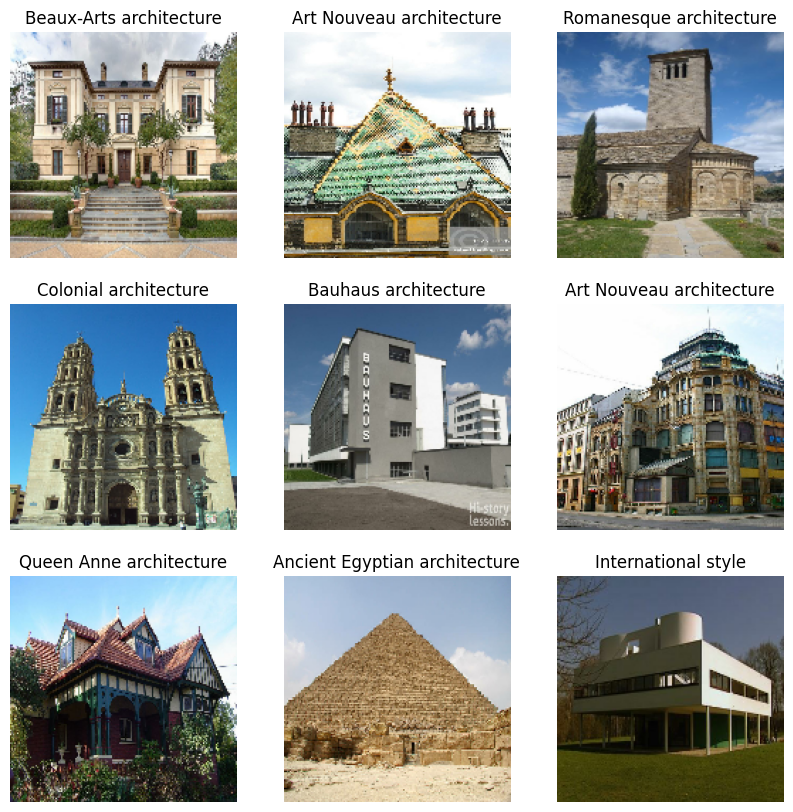

In [11]:
class_names = train_ds.class_names

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [13]:
# create testset 
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 42
Number of test batches: 10


### Configure the dataset for performance

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### Data augmentation

In [21]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.4),
    #layers.RandomBrightness(0.1),
    #layers.RandomContrast(0.1)  # unsure how big effect contrast and brightness has(??)
]  
)
# Here we can add a lot more of them and see what works best.

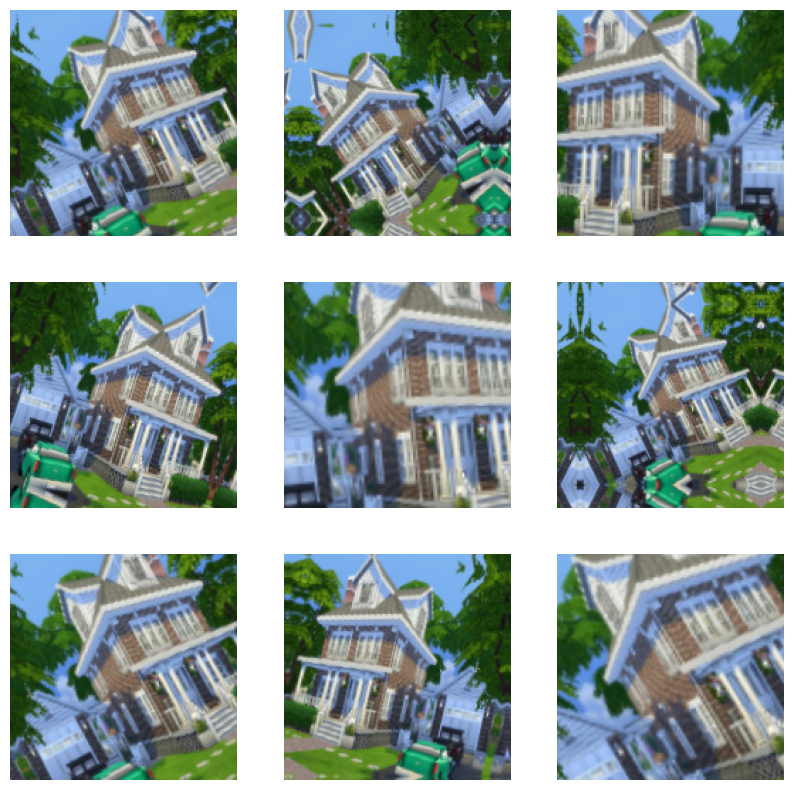

In [22]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [23]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [24]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [25]:
IMG_SHAPE = (img_height, img_width) + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

9406464/9406464 [==============================] - 1s 0us/step


In [26]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


### Feature extraction

In [27]:
# Freeze the convolutional base
base_model.trainable = False

In [28]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [29]:
# Add a classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [30]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


### Model that contains the data augmentation, rescaling, base model and feature extractor layers

In [37]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training =False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [38]:
# Complie the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

### Train the model

Epoch 1/10
253/253 [==============================] - 104s 397ms/step - loss: -80.4535 - accuracy: 0.0357 - val_loss: -115.8401 - val_accuracy: 0.0417
Epoch 2/10
253/253 [==============================] - 138s 545ms/step - loss: -222.3236 - accuracy: 0.0356 - val_loss: -225.0809 - val_accuracy: 0.0395
Epoch 3/10
253/253 [==============================] - 106s 418ms/step - loss: -363.2903 - accuracy: 0.0356 - val_loss: -334.5495 - val_accuracy: 0.0379
Epoch 4/10
253/253 [==============================] - 103s 406ms/step - loss: -505.0914 - accuracy: 0.0356 - val_loss: -434.8061 - val_accuracy: 0.0402
Epoch 5/10
253/253 [==============================] - 100s 394ms/step - loss: -646.5737 - accuracy: 0.0356 - val_loss: -550.1414 - val_accuracy: 0.0387
Epoch 6/10
253/253 [==============================] - ETA: 0s - loss: -789.5390 - accuracy: 0.0356

KeyboardInterrupt: 